**[CVPR 2020] 3D Photography using Context-aware Layered Depth Inpainting**

[project website](https://shihmengli.github.io/3D-Photo-Inpainting/)

- **Prepare environment**


In [1]:
!pip3 install opencv-python==4.2.0.32
!pip3 install vispy==0.6.4
!pip3 install moviepy==1.0.2
!pip3 install transforms3d==0.3.1
!pip3 install networkx==2.3
!sudo apt install sed

     |████████████████████████████████| 28.2MB 107kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 2.3MB 4.0MB/s 
     |████████████████████████████████| 890kB 18.8MB/s 
     |████████████████████████████████| 7.9MB 3.7MB/s 
     |████████████████████████████████| 3.3MB 37.1MB/s 
     |████████████████████████████████| 26.9MB 118kB/s 
  Created wheel for moviepy: filename=moviepy-1.0.2-cp37-none-any.whl size=110730 sha256=83d77fce3e46c94da42867cc48ee290e4b1f113303e2afb98661bf44bd1e585c
  Stored in directory: /root/.cache/pip/wheels/20/49/a9/770a9a22e7a020d796ab3784d2dc4839e38450a1ac87e6106f
  Created wheel for proglog: filename=proglog-0.1.9-cp37-none-any.whl size=6148 sha256=775c1b25c1d18a01ad0cf8a8d6240bbcff173dc089cbba6506

- **Download script and pretrained model**


In [2]:
%cd /content/
!git clone https://github.com/vt-vl-lab/3d-photo-inpainting.git
%cd 3d-photo-inpainting
!sh download.sh

/content
Cloning into '3d-photo-inpainting'...
remote: Enumerating objects: 350, done.
remote: Total 350 (delta 0), reused 0 (delta 0), pack-reused 350
Receiving objects: 100% (350/350), 130.13 MiB | 26.19 MiB/s, done.
Resolving deltas: 100% (192/192), done.
/content/3d-photo-inpainting
downloading from filebox ...
--2021-03-25 16:08:37--  https://filebox.ece.vt.edu/~jbhuang/project/3DPhoto/model/color-model.pth
Resolving filebox.ece.vt.edu (filebox.ece.vt.edu)... 128.173.88.43
Connecting to filebox.ece.vt.edu (filebox.ece.vt.edu)|128.173.88.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206331633 (197M)
Saving to: ‘color-model.pth’

color-model.pth     100%[===================>] 196.77M  14.9MB/s    in 17s     

2021-03-25 16:08:55 (11.6 MB/s) - ‘color-model.pth’ saved [206331633/206331633]

--2021-03-25 16:08:55--  https://filebox.ece.vt.edu/~jbhuang/project/3DPhoto/model/depth-model.pth
Resolving filebox.ece.vt.edu (filebox.ece.vt.edu)... 128.173.88.43


- **Switch off off-screen rendering**

In [3]:
!sed -i 's/offscreen_rendering: True/offscreen_rendering: False/g' argument.yml

Change argument.yml: require_midas: True to require_midas: False

- **Please upload `.jpg` files to `/content/3d-photo-inpainting-master/image/`**
  - You can run this step multiple times to upload multiple `.jpg` files.

In [4]:
%cd image
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
%cd ..

/content/3d-photo-inpainting/image


/content/3d-photo-inpainting


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch.nn as nn
class MobileNetSkipConcat(nn.Module):
    def __init__(self, output_size, pretrained=True):

        super(MobileNetSkipConcat, self).__init__()
        self.output_size = output_size
        mobilenet = MobileNet1()
        if pretrained:
            pretrained_path = os.path.join('imagenet', 'results', 'imagenet.arch=mobilenet.lr=0.1.bs=256', 'model_best.pth.tar')
            checkpoint = torch.load(pretrained_path)
            state_dict = checkpoint['state_dict']

            from collections import OrderedDict
            new_state_dict = OrderedDict()
            for k, v in state_dict.items():
                name = k[7:] # remove `module.`
                new_state_dict[name] = v
            mobilenet.load_state_dict(new_state_dict)
        else:
            mobilenet.apply(weights_init)

        for i in range(14):
            setattr( self, 'conv{}'.format(i), mobilenet.model[i])

        kernel_size = 5
        # self.decode_conv1 = conv(1024, 512, kernel_size)
        # self.decode_conv2 = conv(512, 256, kernel_size)
        # self.decode_conv3 = conv(256, 128, kernel_size)
        # self.decode_conv4 = conv(128, 64, kernel_size)
        # self.decode_conv5 = conv(64, 32, kernel_size)
        self.decode_conv1 = nn.Sequential(
            depthwise(1024, kernel_size),
            pointwise(1024, 512))
        self.decode_conv2 = nn.Sequential(
            depthwise(512, kernel_size),
            pointwise(512, 256))
        self.decode_conv3 = nn.Sequential(
            depthwise(512, kernel_size),
            pointwise(512, 128))
        self.decode_conv4 = nn.Sequential(
            depthwise(256, kernel_size),
            pointwise(256, 64))
        self.decode_conv5 = nn.Sequential(
            depthwise(128, kernel_size),
            pointwise(128, 32))
        self.decode_conv6 = pointwise(32, 1)
        weights_init(self.decode_conv1)
        weights_init(self.decode_conv2)
        weights_init(self.decode_conv3)
        weights_init(self.decode_conv4)
        weights_init(self.decode_conv5)
        weights_init(self.decode_conv6)

    def forward(self, x):
        # skip connections: dec4: enc1
        # dec 3: enc2 or enc3
        # dec 2: enc4 or enc5
        for i in range(14):
            layer = getattr(self, 'conv{}'.format(i))
            x = layer(x)
            # print("{}: {}".format(i, x.size()))
            if i==1:
                x1 = x
            elif i==3:
                x2 = x
            elif i==5:
                x3 = x
        for i in range(1,6):
            layer = getattr(self, 'decode_conv{}'.format(i))
            # print("{}a: {}".format(i, x.size()))
            x = layer(x)
            # print("{}b: {}".format(i, x.size()))
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            if i==4:
                x = torch.cat((x, x1), 1)
            elif i==3:
                x = torch.cat((x, x2), 1)
            elif i==2:
                x = torch.cat((x, x3), 1)
            # print("{}c: {}".format(i, x.size()))
        x = self.decode_conv6(x)
        # print('END', x.size())
        return x

class Result(object):
    def __init__(self):
        self.irmse, self.imae = 0, 0
        self.mse, self.rmse, self.mae = 0, 0, 0
        self.absrel, self.lg10 = 0, 0
        self.delta1, self.delta2, self.delta3 = 0, 0, 0
        self.data_time, self.gpu_time = 0, 0

    def set_to_worst(self):
        self.irmse, self.imae = np.inf, np.inf
        self.mse, self.rmse, self.mae = np.inf, np.inf, np.inf
        self.absrel, self.lg10 = np.inf, np.inf
        self.delta1, self.delta2, self.delta3 = 0, 0, 0
        self.data_time, self.gpu_time = 0, 0

    def update(self, irmse, imae, mse, rmse, mae, absrel, lg10, delta1, delta2, delta3, gpu_time, data_time):
        self.irmse, self.imae = irmse, imae
        self.mse, self.rmse, self.mae = mse, rmse, mae
        self.absrel, self.lg10 = absrel, lg10
        self.delta1, self.delta2, self.delta3 = delta1, delta2, delta3
        self.data_time, self.gpu_time = data_time, gpu_time

    def evaluate(self, output, target):
        valid_mask = ((target>0) + (output>0)) > 0

        output = 1e3 * output[valid_mask]
        target = 1e3 * target[valid_mask]
        abs_diff = (output - target).abs()

        self.mse = float((torch.pow(abs_diff, 2)).mean())
        self.rmse = math.sqrt(self.mse)
        self.mae = float(abs_diff.mean())
        self.lg10 = float((log10(output) - log10(target)).abs().mean())
        self.absrel = float((abs_diff / target).mean())

        maxRatio = torch.max(output / target, target / output)
        self.delta1 = float((maxRatio < 1.25).float().mean())
        self.delta2 = float((maxRatio < 1.25 ** 2).float().mean())
        self.delta3 = float((maxRatio < 1.25 ** 3).float().mean())
        self.data_time = 0
        self.gpu_time = 0

        inv_output = 1 / output
        inv_target = 1 / target
        abs_inv_diff = (inv_output - inv_target).abs()
        self.irmse = math.sqrt((torch.pow(abs_inv_diff, 2)).mean())
        self.imae = float(abs_inv_diff.mean())



Loads Model

In [6]:
import torch
checkpoint = torch.load("/content/drive/MyDrive/results/Dataset=nyudepthv2 -- Network=mobilenet -- Loss=BerHu -- lr=0.01 -- bs=8/model_best.pth.tar")
model = checkpoint['model']

Produce Prediction

In [15]:
from PIL import Image
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

img_path="/content/3d-photo-inpainting/image/ReDWeb_Sample.jpg"
image = Image.open(img_path)
image = ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
image = Variable(image)
image = image.cuda()
print(image.shape)

pred = model(image.to(dtype=torch.float))
pred_c = pred.squeeze(0).squeeze(0).cpu().detach().numpy()

torch.Size([1, 3, 224, 224])


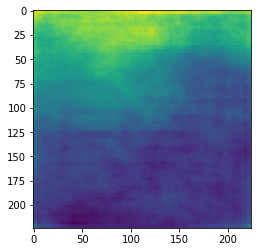

In [16]:
plt.imshow(pred_c)

Save depth as npy and png format

In [17]:
import numpy as np
np.save("/content/3d-photo-inpainting/depth/ReDWeb_Sample.npy",pred_c)
plt.savefig("/content/3d-photo-inpainting/depth/ReDWeb_Sample.png")

<Figure size 432x288 with 0 Axes>

- **Execute the 3D Photo Inpainting**
  - Note: The 3D photo generation process usually takes about 2-3 minutes or more depending on the available computing resources.

In [18]:
!python main.py --config argument.yml

running on device 0
  0% 0/1 [00:00<?, ?it/s]Current Source ==>  ReDWeb_Sample
Running depth extraction at 1616689049.1634347
Start Running 3D_Photo ...
Loading edge model at 1616689061.2317262
Loading depth model at 1616689063.5167317
Loading rgb model at 1616689064.4793072
Writing depth ply (and basically doing everything) at 1616689065.4013197
Writing mesh file mesh/ReDWeb_Sample.ply ...
Making video at 1616689246.0316343
fov: 53.13010235415598
Moviepy - Building video video/ReDWeb_Sample_dolly-zoom-in.mp4.
Moviepy - Writing video video/ReDWeb_Sample_dolly-zoom-in.mp4

  0% 0/1 [03:59<?, ?it/s]
t:   0% 0/241 [00:00<?, ?it/s, now=None]
t:   1% 2/241 [00:00<00:15, 15.59it/s, now=None]
t:   1% 3/241 [00:00<00:20, 11.79it/s, now=None]
t:   6% 14/241 [00:00<00:14, 16.10it/s, now=None]
t:  10% 25/241 [00:00<00:10, 21.55it/s, now=None]
t:  15% 36/241 [00:00<00:07, 28.22it/s, now=None]
t:  19% 46/241 [00:00<00:05, 35.88it/s, now=None]
t:  22% 54/241 [00:01<00:06, 28.02it/s, now=None]
t:  25